In [240]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.model_selection import train_test_split

In [246]:
"""
Created on Sun Jul 31 22:13:45 2022

@author: Junhyun
"""

class Recursive_LSTM():

    def __init__(self):
        self.data = None
        
        
    def TimeSeriesDataTransform(self, data, lag):
        """
        ※ 참조 코드 : http://103.60.126.183:8150/gidatalab (LSTM)

        데이터를 변환하기 위해서는 Y값이 맨 왼쪽에 위치해있어야함 

        To transoform data to timeseries data, target data(Y) have to be located at leftmost

        Parameters
        ----------
        data : DataFrame
            data
        lag : int
            시계열 예측에서 데이터를 미는 시점 (= Time sequence)

        Returns
        -------
        agg :  DataFrame
            시계열 에측이 가능하도록 변환된 데이터

        """
        if isinstance(self.data, np.ndarray):
            data = pd.DataFrame(self.data)
        elif isinstance(self.data, pd.core.series.Series):
            data = pd.DataFrame(self.data)

        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)

        cols, names = list(), list()

        # 입력값의 순서 (t-n, ... t-1)
        for i in range(lag, 0, -1):
            cols.append(df.shift(i))
            names += [('%s(t-%d)' % (data.columns[j], i)) for j in range(n_vars)]

        # 예측의 순서 (t, t+1, ... t+n)
        for i in range(0, 1):
            cols.append(df.shift(-i))
            if i == 0:
                names += [('%s(t)' % (data.columns[j])) for j in range(n_vars)]
            else:
                names += [('%s(t+%d)' % (data.columns[j], i)) for j in range(n_vars)]

        # 합치기
        agg = pd.concat(cols, axis=1)
        agg.columns = names

        # NaN 값의 row를 제거
        agg.dropna(inplace=True)

        # 인덱스 초기화
        agg = agg.reset_index(drop=True)
        
        # Y(t)까지 데이터만 사용
        agg = agg.iloc[:,0:(data.shape[1]*lag)+1]

        return agg
        
    def LSTM_model(self, X_train, X_test, y_train, y_test, epochs=50):
        """

        Parameters
        ----------
        X_train : Array
            Train input data, shape=(nrow, lag, ncol)
        X_test : Array
            Test input data, shape=(nrow, lag, ncol)
        y_train : Array
            Train input data, shape=(nrow,)
        y_test : Array
            Train input data, shape=(nrow,)
        epochs : int
            LSTM 학습횟수

        Returns
        -------
        trainPrediction : Array
            Train Prediction
        testPrediction : Array
            Test Prediction

        """
        
    
        # LSTM의 구조
        model = Sequential()
        model.add(LSTM(8, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu')) # 하나의 층 8개의 노드, return_sequences=True 필수
        model.add(LSTM(4, activation='relu', return_sequences=False)) # 하나의층, 4개의 노드, 마지막에는 return_sequences=False
        model.add(Dense(1)) # 노드가 하나인 구조를 만들었다 (하나의 예측값으로 표현하기 위해)

        # model compile
        model.compile(loss='mse', optimizer='adam')

        # fit network
        history = model.fit(X_train, y_train, epochs=epochs, verbose=0, shuffle=False) # epochs : 반복횟수

        lstm_train_pred = model.predict(X_train)
        lstm_test_pred = model.predict(X_test)

        return({'trainPrediction':lstm_train_pred, 'testPrediction':lstm_test_pred})
        
    # Recursive LSTM model
    def RLSTM_model(self, X, y, trainCycle=10, predictionCycle=5, Cycle=5, epochs=50):
        """

        Parameters
        ----------
        X : Array  
            Input data, shape=(nrow, lag, ncol)
        y : Array
            Output data, shape=(nrow,)
        trainCycle : int
            며칠 주기로 학습할 것인지 
        predictionCycle : int
            며칠 주기로 예측할 것인지
        Cycle : int
            위 과정을 몇번 반복할 것인지
        epochs : int
            LSTM 학습 횟수

        Returns
        -------
        recursive_test_pred : Array
            test 데이터를 recursive하게 예측한 결과


        예시)
        1row = 1일일때, 
        trainCycle = 5 -> 5일 주기로 학습
        predictionCycle = 2 -> 2일 주기로 예측

        1월 1일 데이터가 있다고 가정

        - 1월 1일 ~ 1월 5일 (5일) 학습 후, 1월 6일~1월 7일 (2일) 예측 (1cycle)
        - 1월 3일 ~ 1월 7일 (5일) 학습 후, 1월 8일~1월 9일 (2일) 예측 (2cycle) (1월 6일은 실제 데이터임 (예측한 데이터 X)) (현재시점까지 왔다고 가정)
        - 1월 5일 ~ 1월 9일 (5일) 학습 후, 1월 10일~1월 11일 (2일) (1일) 예측 (3cycle) (1월 7일은 실제 데이터임 (예측한 데이터 X)) (현재시점까지 왔다고 가정)


        """
        
        # Recursive Prediction
        recursive_test_pred = np.array([])

        for i in range(Cycle):
            
            # Recursive prediction
            recursive_X_train = X[(predictionCycle*i):(trainCycle+predictionCycle*i),:,:]
            recursive_y_train = y[(predictionCycle*i):(trainCycle+predictionCycle*i),]

            recursive_X_test = X[(trainCycle+predictionCycle*i):(trainCycle+predictionCycle*(i+1)),:]
            recursive_y_test = y[(trainCycle+predictionCycle*i):(trainCycle+predictionCycle*(i+1)),]

            lstm_pred = LSTM_model(recursive_X_train, recursive_X_test, recursive_y_train, recursive_y_test, epochs = epochs)
            
            recursive_test_pred = np.append(recursive_test_pred, lstm_pred['testPrediction'])
            
        return(recursive_test_pred)

    def maxCycleNum(self, data, trainCycle=10, predictionCycle=5):
        
        """
        
        Parameters
        ----------
        data : DataFrame
            data
        trainCycle : int
            며칠 주기로 학습할 것인지 
        predictionCycle : int
            며칠 주기로 예측할 것인지

        Returns
        -------
        maxCycle : int
            Recursive 하게 예측할 수 있는 최대 cycle 수


        """
        
        self.maxCycle = int((data.shape[0] - trainCycle) / predictionCycle) - 1

        print('Max Cycle Number : %d' % self.maxCycle)

        return(self.maxCycle)


In [282]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
data = iris['data']

In [283]:
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [315]:
# 클래스 선언
rlstm = Recursive_LSTM()

lag = 3
reframed = rlstm.TimeSeriesDataTransform(data, lag=lag)

In [327]:
# X, y
X = reframed.values[:,0:-1]
y = reframed.values[:,-1]

In [331]:
# MinMax Scaler
scaler = MinMaxScaler()
scaler = MinMaxScaler(feature_range=(0, 1)) # 0~1사이로 scale
scaled = scaler.fit_transform(X)

In [342]:
X = X.reshape(X.shape[0], lag, data.shape[1])
y = y

(150, 4)

In [345]:
# X_train, X_test, y_Train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [346]:
# LSTM
lstm_pred = rlstm.LSTM_model(X_train, X_test, y_train, y_test, epochs=1)

2/2 [==============================] - 0s 3ms/step


In [348]:
maxCycle = rlstm.maxCycleNum(X, trainCycle=50, predictionCycle=5)

Max Cycle Number : 18


In [350]:
# Recursive LSTM
rlstm_pred = rlstm.RLSTM_model(X, y, trainCycle=10, predictionCycle=5, Cycle=maxCycle, epochs=1)

1/1 [==============================] - 0s 21ms/step


In [351]:
rlstm_pred

array([ 5.35412244e-02,  4.84791361e-02,  5.27986102e-02,  5.99404834e-02,
        6.61182404e-02, -3.53066295e-01, -3.20823610e-01, -3.25776756e-01,
       -3.34629178e-01, -3.21015298e-01,  7.02817691e-03,  6.13599643e-03,
        2.82073952e-03, -5.81358909e-04, -6.83912891e-04, -9.71754491e-02,
       -1.01266995e-01, -1.01371221e-01, -9.71401036e-02, -9.45365131e-02,
        2.16024891e-01,  2.25053594e-01,  2.46405751e-01,  2.41295218e-01,
        2.19095156e-01, -1.02493241e-02, -1.35399513e-02, -1.10130124e-02,
       -9.67587624e-03, -1.46942083e-02, -1.24189526e-01, -1.18392579e-01,
       -1.14232123e-01, -1.17778502e-01, -1.12533741e-01, -4.75499481e-01,
       -4.84240353e-01, -4.68708187e-01, -6.17010593e-01, -7.60917008e-01,
       -5.78907318e-02, -3.05141527e-02, -4.15957533e-02, -3.01722158e-02,
       -4.09164019e-02,  4.18081105e-01,  4.77769196e-01,  3.99836540e-01,
        4.00509298e-01,  4.07177925e-01, -4.97217000e-01, -5.26474476e-01,
       -5.19389451e-01, -

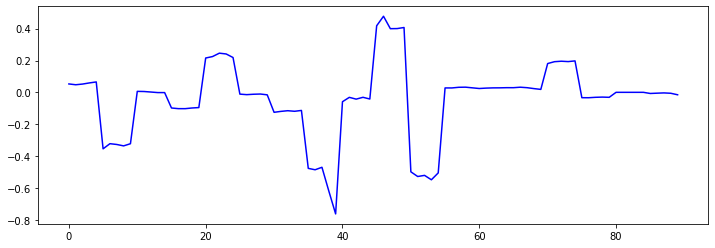

In [352]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(rlstm_pred, color='blue')
plt.show()